In [1]:
%load_ext cython
%load_ext line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
import numba
import numpy as np
import scipy as sp
import seaborn as sns
%load_ext watermark
%watermark
%watermark -p scipy

2017-12-21T19:22:18+01:00

CPython 3.6.3
IPython 6.1.0

compiler   : GCC 7.2.0
system     : Linux
release    : 4.4.92-18.36-default
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
scipy 0.19.1


In [2]:
import atm_c14_data
import c14_individuals_data

# Atmospheric C14 function

In [3]:
@numba.njit
def C_atm(x):
    x -=1
    xp = np.array([ 1891.5, 1892.5, 1893.5, 1894.5, 1895.5, 1896.5, 1897.5, 1898.5, 1899.5, 1900.5, 1901.5, 1902.5, 1903.5, 1904.5, 1905.5, 1906.5, 1907.5, 1908.5, 1909.5, 1910.5, 1911.5, 1912.5, 1913.5, 1914.5, 1915.5, 1916.5, 1917.5, 1918.5, 1919.5, 1920.5, 1921.5, 1922.5, 1923.5, 1924.5, 1925.5, 1926.5, 1927.5, 1928.5, 1929.5, 1930.5, 1931.5, 1932.5, 1933.5, 1934.5, 1935.5, 1936.5, 1937.5, 1938.5, 1939.5, 1940.5, 1941.5, 1942.5, 1943.5, 1944.5, 1945.5, 1946.5, 1947.5, 1948.5, 1949.5, 1950.5, 1951.5, 1952.5, 1953.5, 1954.5, 1955.5, 1956.5, 1957.5, 1958.5, 1959.5, 1960.5, 1961.5, 1962.5, 1963.5, 1964.5, 1965.5, 1966.5, 1967.5, 1968.5, 1969.5, 1970.5, 1971.5, 1972.5, 1973.5, 1974.5, 1975.5, 1976.5, 1977.5, 1978.5, 1979.5, 1980.5, 1981.5, 1982.5, 1983.5, 1984.5, 1985.5, 1986.5, 1987.5, 1988.5, 1989.5, 1990.5, 1991.5, 1992.5, 1993.5, 1994.5, 1995.5, 1996.5, 1997.5, 1998.5, 1999.5, 2000.5, 2001.5, 2002.5, 2003.5, 2003.963938,  2004.421821,  2004.879704, 2005.337587,  2005.79547 ,  2006.253353,  2006.711236, 2007.169119,  2007.627002,  2008.084885,  2008.542768, 2009.000651,  2009.458534,  2009.916417,  2010.3743  , 2010.3743  ,  2010.626   ,  2011.125   ,  2011.626   , 2012.125   ,  2012.626   ,  2013.125   ,  2013.626   , 2014.125   ,  2014.626   ,  2015.125   ,  2015.625   , 2016.125   ,  2016.625   ,  2020.      ])
    fp = np.array([-0.002     , -0.002     , -0.002     , -0.002     , -0.002     , -0.00233   , -0.00267   , -0.003     , -0.00333   , -0.00367   , -0.004     , -0.00433   , -0.00467   , -0.005     , -0.00533   , -0.00567   , -0.006     , -0.00633   , -0.00667   , -0.007     , -0.00733   , -0.00767   , -0.008     , -0.00833   , -0.00867   , -0.009     , -0.00933   , -0.00967   , -0.01      , -0.01033   , -0.01067   , -0.011     , -0.01133   , -0.01167   , -0.012     , -0.01233   , -0.01267   , -0.013     , -0.01333   , -0.01367   , -0.014     , -0.01433   , -0.01467   , -0.015     , -0.01533   , -0.01567   , -0.016     , -0.01633   , -0.01667   , -0.0202    , -0.0194    , -0.0196    , -0.0225    , -0.0217    , -0.0221    , -0.0216    , -0.0211    , -0.0223    , -0.0246    , -0.0248    , -0.0248    , -0.0249    , -0.0239    , -0.0211    , -0.0082    , 0.0265    ,  0.073     ,  0.1402    ,  0.228     ,  0.2123    , 0.2216    ,  0.3585    ,  0.7183    ,  0.8357    ,  0.7563    , 0.6919    ,  0.6236    ,  0.5645    ,  0.5454    ,  0.5291    , 0.4994    ,  0.4656    ,  0.4186    ,  0.4008    ,  0.3698    , 0.3525    ,  0.3339    ,  0.3258    ,  0.2958    ,  0.2645    , 0.2567    ,  0.2383    ,  0.2242    ,  0.2093    ,  0.2013    , 0.1911    ,  0.1826    ,  0.1734    ,  0.1635    ,  0.1525    , 0.1429    ,  0.1364    ,  0.1284    ,  0.1221    ,  0.1155    , 0.1099    ,  0.1043    ,  0.0981    ,  0.09      ,  0.0866    , 0.0807    ,  0.0749    ,  0.0689    ,  0.06349874,  0.06145905, 0.0597412 ,  0.05822747,  0.05641489,  0.05479531,  0.05364811, 0.05205465,  0.05067073,  0.04927897,  0.04788014,  0.04647508, 0.04506462,  0.04364948,  0.04223027,  0.04223027,  0.0403    , 0.0347    ,  0.0371    ,  0.0312    ,  0.0299    ,  0.0193    , 0.0219    ,  0.0182    ,  0.018     ,  0.0116    ,  0.0129    , 0.0096    ,  0.0097    ,  0.0097    ])
    
    if x<xp[0]:
        return fp[0]
    elif x>xp[-1]:
        return fp[-1]
    else:
        for i in range(len(xp)):
            if x<xp[i]:
                break
        return fp[i-1] + (fp[i] - fp[i-1]) * (x - xp[i-1]) / (xp[i] - xp[i-1])

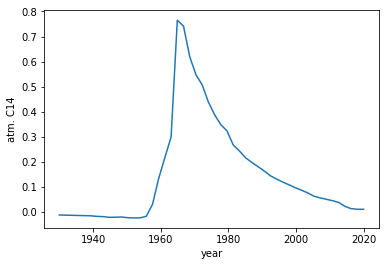

In [4]:
tt = np.linspace(1930, 2020)
plt.plot(tt, np.vectorize(C_atm)(tt))

plt.xlabel('year')
plt.ylabel('atm. C14')

plt.show()

# Single-daughter cell division model

## Discretization of master equation

In [5]:
@numba.njit
def f(t, C):
    return 0.5 * (C + C_atm(t))

@numba.njit
def find_nearest(C, CC):
    dC = (CC[1] - CC[0])/ (CC[-1] - CC[0]) 
    i = np.rint((C - CC[0])/ (CC[-1] - CC[0]) /dC)
    i = i.astype(np.int16)
    return i

@numba.njit
def k(t, CC, C):
    return find_nearest(f(t, C), CC)

@numba.njit
def kCC(t, CC):
    return k(t, CC, CC)

@numba.njit
def target_matrix(t, CC):
    n = len(CC)
    T = np.zeros((n, n))
    k = kCC(t, CC)
    for j, i in enumerate(k):
        T[i, j] = 1.0
    return T

@numba.njit
def rate_matrix(t, CC):
    T = target_matrix(t, CC)
    A = T - np.eye(len(CC))
    return A

@numba.njit
def rhs(N, t0, CC, r):
    A = rate_matrix(t0, CC)
    dNdt = r * A @ N
    return dNdt

@numba.jit
def C_L1a(Dbirth, Dcoll, r, n=3, dt = 0.1):
    C_min = -0.024899999999999999
    C_max = 0.8357
    
    CC = np.linspace(C_min, C_max, n)
    
    N0 = np.zeros(n)
    N0[find_nearest(np.array([C_atm(Dbirth)]), CC)] = 1
    
    t= (Dbirth, Dcoll)
    sol = sp.integrate.odeint(rhs, N0, t, args=(CC, r), mxstep=int(1e5))
    N = sol[-1]
    C = np.average(CC, weights=N)
    return C

## Gillespie

In [6]:
@numba.njit
def C_L1_cell(Dbirth, Dcoll, r, C_init=-99.9):
    t = Dbirth
    
    if C_init==-99.9:
        C_init = C_atm(t)
    c = C_init
    
    while True:
        t += np.random.exponential(1/r)
        if t > Dcoll:
            break
        else:
            c = 0.5 * (c + C_atm(t))
    return c

@numba.njit
def C_L1b(Dbirth, Dcoll, r, N=1000, C_init=-99.9):
    cc = np.array([C_L1_cell(Dbirth, Dcoll, r, C_init) for i in range(N)])
    return cc.mean()

## First moment

In [7]:
def C_L1c(Dbirth, Dcoll, r, C_init=-99.9):
    if C_init==-99.9:
        C_init = C_atm(Dbirth)
    c = C_init
    
    def rhs(c, t, r):
        return 0.5 * r * (C_atm(t) - c)
    def Dfun(c, t0, r):
        return -0.5 * r
    C = sp.integrate.odeint(rhs, C_init, np.linspace(Dbirth, Dcoll), args = (r, ), Dfun = Dfun)[-1, 0]
    return C

## Compare

In [ ]:
C_L1a(1930, 2015, 0.1, n=30)

In [ ]:
C_L1b(1930, 2015, 0.1, 10000)

In [ ]:
C_L1c(1930, 2015, 0.1)

In [ ]:
%timeit C_L1a(1930, 2015, 0.1, n=30)
%timeit C_L1b(1930, 2015, 0.1, 10000)
%timeit C_L1c(1930, 2015, 0.1)

# simple $n$ cell model

## Gillespie

In [8]:
@numba.njit
def C_L2a(Dbirth, Dcoll, lam, mu, n, C_init=-99.9):
    t = Dbirth
    
    if C_init==-99.9:
        C_init = C_atm(t)
    cc = [C_init for i in range(n)]
    
    # Pre-allocated propensity vector, no values yet
    aa = np.empty(2)
    
    while True:
        n = len(cc)
        
        aa[0] = lam * n
        aa[1] = mu * n
        
        t += np.random.exponential(1/aa.sum())
        
        p_division = aa[0] / aa.sum()
        
        division_event = np.random.binomial(1, p_division)
        
        if division_event:
            # cell division
            # select random cell
            i = np.random.randint(n)
            # get C14 concentration from a random cell and delete this cell
            c = cc.pop(i)
            # calculate new C14 concentration
            c = 0.5 * (c + C_atm(t))
            # add two new cells with updated concentration
            cc.append(c)
            cc.append(c)
        else:
            # cell death
            # select random cell
            i = np.random.randint(n)
            # delete it
            cc.pop(i)
        
        if t > Dcoll:
            break
    return np.mean(np.array(cc))

In [9]:
@np.vectorize
def C_L2a_trajectory(t, lam, n=100):
    return C_L2a(0.0, t, lam, lam, n)

## Empirical ODE

In [10]:
def L2b(Dbirth, Dcoll, r, C_init=-99.9, timing=False):
    if C_init==-99.9:
        C_init = C_atm(Dbirth)
    c = C_init
    
    def rhs(c, t, r):
        return r * (C_atm(t) - c)
    def Dfun(c, t0, r):
        return -r
    tt = np.linspace(Dbirth, Dcoll)
    CC = sp.integrate.odeint(rhs, C_init, tt, args = (r, ), Dfun = Dfun)[:, 0]
    
    if timing:
        return tt, CC
    else:
        return CC[-1]

## Compare

In [ ]:
tt = np.linspace(1930, 2015, 10)

lam = 0.1

plt.plot(tt, C_L2a_trajectory(tt, lam, n=1000))
plt.plot(tt, [L2b(0, t, lam) for t in tt])
# plt.plot(tt, np.exp(-lam*tt))

# plt.plot(tt, [C_L1b(0, t, lam, N=1000, C_init=1.0) for t in tt])
# plt.plot(tt, np.exp(-0.5*lam*tt))

plt.show()

# Scenario A

## Gillespie

In [11]:
@numba.njit
def C_Aa_cell(Dbirth, Dcoll, r, C_init=-99.9):
    t = Dbirth
    
    if C_init==-99.9:
        C_init = C_atm(t)
    c = C_init
    
    while True:
        t += np.random.exponential(1/r)
        if t > Dcoll:
            return c
        else:
            c = C_atm(t)
    

@numba.njit
def C_Aa(Dbirth, Dcoll, r, N=1000, C_init=-99.9):
    cc = np.array([C_Aa_cell(Dbirth, Dcoll, r, C_init) for i in range(N)])
    return cc.mean()

## Bernard

In [12]:
import c14_models

In [13]:
c14_models.C_scenario_A

<function c14_models.C_scenario_A>

## Compare

In [ ]:
# @numba.njit
# def C_atm(x):
#     return 0.0

lam = 0.1
tt = np.linspace(0.01, 90)
Dbirth = 1930

plt.plot(Dbirth+tt, [C_Aa(Dbirth, Dbirth+t, lam) for t in tt])
plt.plot(Dbirth+tt, [c14_models.C_scenario_A(Dbirth, Dbirth+t, lam) for t in tt])
# plt.plot(tt, np.exp(-lam*tt))

plt.plot(Dbirth+tt, [C_L1c(Dbirth, Dbirth+t, 2*lam) for t in tt])

plt.show()

# Scenario LD

Age-dependent rates

## Time-discrete implementation

In [14]:
# @numba.njit
# def C_atm(t):
#     if t<1980:
#         return 1.0
#     else:
#         return 0.0
    
@numba.njit
def C_atm(x):
    x -=1
    xp = np.array([ 1891.5, 1892.5, 1893.5, 1894.5, 1895.5, 1896.5, 1897.5, 1898.5, 1899.5, 1900.5, 1901.5, 1902.5, 1903.5, 1904.5, 1905.5, 1906.5, 1907.5, 1908.5, 1909.5, 1910.5, 1911.5, 1912.5, 1913.5, 1914.5, 1915.5, 1916.5, 1917.5, 1918.5, 1919.5, 1920.5, 1921.5, 1922.5, 1923.5, 1924.5, 1925.5, 1926.5, 1927.5, 1928.5, 1929.5, 1930.5, 1931.5, 1932.5, 1933.5, 1934.5, 1935.5, 1936.5, 1937.5, 1938.5, 1939.5, 1940.5, 1941.5, 1942.5, 1943.5, 1944.5, 1945.5, 1946.5, 1947.5, 1948.5, 1949.5, 1950.5, 1951.5, 1952.5, 1953.5, 1954.5, 1955.5, 1956.5, 1957.5, 1958.5, 1959.5, 1960.5, 1961.5, 1962.5, 1963.5, 1964.5, 1965.5, 1966.5, 1967.5, 1968.5, 1969.5, 1970.5, 1971.5, 1972.5, 1973.5, 1974.5, 1975.5, 1976.5, 1977.5, 1978.5, 1979.5, 1980.5, 1981.5, 1982.5, 1983.5, 1984.5, 1985.5, 1986.5, 1987.5, 1988.5, 1989.5, 1990.5, 1991.5, 1992.5, 1993.5, 1994.5, 1995.5, 1996.5, 1997.5, 1998.5, 1999.5, 2000.5, 2001.5, 2002.5, 2003.5, 2003.963938,  2004.421821,  2004.879704, 2005.337587,  2005.79547 ,  2006.253353,  2006.711236, 2007.169119,  2007.627002,  2008.084885,  2008.542768, 2009.000651,  2009.458534,  2009.916417,  2010.3743  , 2010.3743  ,  2010.626   ,  2011.125   ,  2011.626   , 2012.125   ,  2012.626   ,  2013.125   ,  2013.626   , 2014.125   ,  2014.626   ,  2015.125   ,  2015.625   , 2016.125   ,  2016.625   ,  2020.      ])
    fp = np.array([-0.002     , -0.002     , -0.002     , -0.002     , -0.002     , -0.00233   , -0.00267   , -0.003     , -0.00333   , -0.00367   , -0.004     , -0.00433   , -0.00467   , -0.005     , -0.00533   , -0.00567   , -0.006     , -0.00633   , -0.00667   , -0.007     , -0.00733   , -0.00767   , -0.008     , -0.00833   , -0.00867   , -0.009     , -0.00933   , -0.00967   , -0.01      , -0.01033   , -0.01067   , -0.011     , -0.01133   , -0.01167   , -0.012     , -0.01233   , -0.01267   , -0.013     , -0.01333   , -0.01367   , -0.014     , -0.01433   , -0.01467   , -0.015     , -0.01533   , -0.01567   , -0.016     , -0.01633   , -0.01667   , -0.0202    , -0.0194    , -0.0196    , -0.0225    , -0.0217    , -0.0221    , -0.0216    , -0.0211    , -0.0223    , -0.0246    , -0.0248    , -0.0248    , -0.0249    , -0.0239    , -0.0211    , -0.0082    , 0.0265    ,  0.073     ,  0.1402    ,  0.228     ,  0.2123    , 0.2216    ,  0.3585    ,  0.7183    ,  0.8357    ,  0.7563    , 0.6919    ,  0.6236    ,  0.5645    ,  0.5454    ,  0.5291    , 0.4994    ,  0.4656    ,  0.4186    ,  0.4008    ,  0.3698    , 0.3525    ,  0.3339    ,  0.3258    ,  0.2958    ,  0.2645    , 0.2567    ,  0.2383    ,  0.2242    ,  0.2093    ,  0.2013    , 0.1911    ,  0.1826    ,  0.1734    ,  0.1635    ,  0.1525    , 0.1429    ,  0.1364    ,  0.1284    ,  0.1221    ,  0.1155    , 0.1099    ,  0.1043    ,  0.0981    ,  0.09      ,  0.0866    , 0.0807    ,  0.0749    ,  0.0689    ,  0.06349874,  0.06145905, 0.0597412 ,  0.05822747,  0.05641489,  0.05479531,  0.05364811, 0.05205465,  0.05067073,  0.04927897,  0.04788014,  0.04647508, 0.04506462,  0.04364948,  0.04223027,  0.04223027,  0.0403    , 0.0347    ,  0.0371    ,  0.0312    ,  0.0299    ,  0.0193    , 0.0219    ,  0.0182    ,  0.018     ,  0.0116    ,  0.0129    , 0.0096    ,  0.0097    ,  0.0097    ])
    
    if x<xp[0]:
        return fp[0]
    elif x>xp[-1]:
        return fp[-1]
    else:
        for i in range(len(xp)):
            if x<xp[i]:
                break
        return fp[i-1] + (fp[i] - fp[i-1]) * (x - xp[i-1]) / (xp[i] - xp[i-1])

def L2b(Dbirth, Dcoll, r, C_init=-99.9):
    if C_init==-99.9:
        C_init = C_atm(Dbirth)
    c = C_init
    
    def rhs(c, t, r):
        return r * (C_atm(t) - c)
    def Dfun(c, t0, r):
        return -r
    tt = np.linspace(Dbirth, Dcoll)
    CC = sp.integrate.odeint(rhs, C_init, tt, args = (r, ), Dfun = Dfun)[:, 0]
    return tt, CC

@numba.njit
def k(a, g0, g1):
    return g0 * g1 / (g1 + a)

@numba.njit
def LDa(Dbirth, Dcoll, g0, g1, C_init=-99.9, N=1000, dt=0.1):
    t = Dbirth
    
    if C_init==-99.9:
        C_init = C_atm(t)
    cc = C_init * np.ones(N)
    aa = np.zeros(N)
    
    tt = np.arange(Dbirth, Dcoll, dt)
    cc_mean = np.empty_like(tt)
    
    for i, t in enumerate(tt):
        pp = k(aa, g0, g1) * dt
        
        div = np.random.rand(N) < pp
        div_ind = np.where(div)[0]
        
        die_ind = np.random.choice(np.where(~div)[0], size=len(div_ind), replace=False)
        
        cc_new = 0.5 * (cc[div_ind] + C_atm(t))
        
        cc[div_ind] = cc_new
        aa[div_ind] = 0.0
        
        cc[die_ind] = cc_new
        aa[die_ind] = 0.0
        
        cc_mean[i] = cc.mean()
        
        aa += dt
    return aa, tt, cc_mean

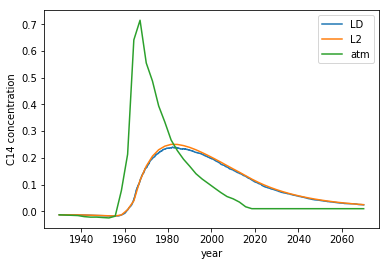

In [15]:
np.random.seed(42)
g0 = 0.1
g1 = 5.0

np.random.seed(42)
aa, tt_LD, CC_LD = LDa(1930, 2070, g0, g1, N=1000, dt=0.001)
plt.plot(tt_LD, CC_LD, label = 'LD')

r1 = k(aa, g0, g1).mean()

tt_L2, CC_L2 = L2b(1930, 2070, r1)
plt.plot(tt_L2, CC_L2, label = 'L2')

plt.plot(tt_L2, np.vectorize(C_atm)(tt_L2), label='atm')

plt.xlabel('year')
plt.ylabel('C14 concentration')
plt.legend()

plt.show()